In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [4]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [5]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-10-30 20:13:09--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.004s  

2020-10-30 20:13:10 (17.1 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



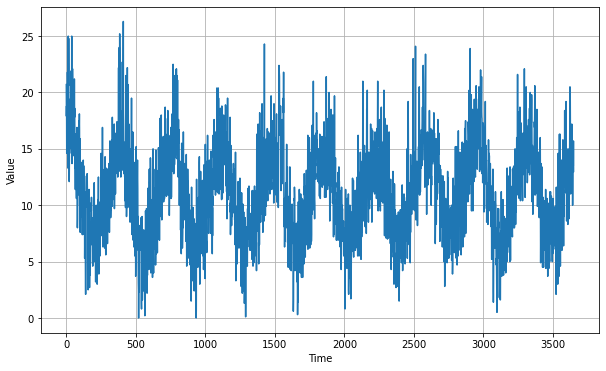

In [6]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step=step+1
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [7]:
split_time = 2500
time_train = time[:split_time]# YOUR CODE HERE
x_train = series[:split_time]# YOUR CODE HERE
time_valid = time[split_time:]# YOUR CODE HERE
x_valid = series[split_time:]# YOUR CODE HERE

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [18]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(dataset)
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(window_size+1))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.map(lambda x: (x[:-1], x[-1:]))
  return dataset.batch(batch_size).prefetch(1)
    # YOUR CODE HERE

In [26]:
def model_forecast(model, series, window_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(window_size))
  dataset = dataset.batch(32).prefetch(1)
  forcast = model.predict(dataset)
  return forcast
    # YOUR CODE HERE

In [22]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1,
                         padding="causal", activation="relu",
                         input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x*400)
# YOUR CODE HERE
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 0s 25ms/step - loss: 31.1418 - mae: 31.6401
Epoch 2/100
10/10 [==============================] - 0s 24ms/step - loss: 30.5657 - mae: 31.0639
Epoch 3/100
10/10 [==============================] - 0s 24ms/step - loss: 29.6745 - mae: 30.1726
Epoch 4/100
10/10 [==============================] - 0s 22ms/step - loss: 28.5571 - mae: 29.0549
Epoch 5/100
10/10 [==============================] - 0s 25ms/step - loss: 27.1948 - mae: 27.6923
Epoch 6/100
10/10 [==============================] - 0s 24ms/step - loss: 25.4979 - mae: 25.9952
Epoch 7/100
10/10 [==============================] - 0s 25ms/step - loss: 23.3389 - mae: 23.8356
Epoch 8/100
10/10 [==============================] - 0s 24ms/step - loss: 20.5994 - mae: 21.0955
Epoch 9/100
10/10 [==============================] - 0s 23ms/step - loss: 17.2908 - mae: 17.7858
Epoch 10/100
10/10 [=====

(1e-08, 0.0001, 0.0, 60.0)

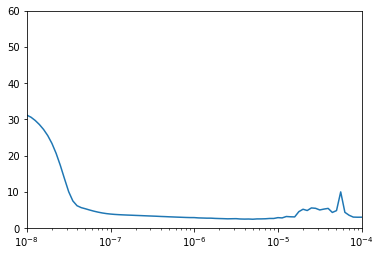

In [23]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [24]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1,
                         padding="causal", activation="relu",
                         input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x*400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/150
25/25 [==============================] - 0s 15ms/step - loss: 12.1578 - mae: 12.6495
Epoch 2/150
25/25 [==============================] - 0s 15ms/step - loss: 3.5661 - mae: 4.0406
Epoch 3/150
25/25 [==============================] - 0s 14ms/step - loss: 2.5598 - mae: 3.0243
Epoch 4/150
25/25 [==============================] - 0s 14ms/step - loss: 2.6306 - mae: 3.0963
Epoch 5/150
25/25 [==============================] - 0s 13ms/step - loss: 2.9352 - mae: 3.4063
Epoch 6/150
25/25 [==============================] - 0s 15ms/step - loss: 2.4490 - mae: 2.9118
Epoch 7/150
25/25 [==============================] - 0s 14ms/step - loss: 2.3605 - mae: 2.8224
Epoch 8/150
25/25 [==============================] - 0s 14ms/step - loss: 2.4999 - mae: 2.9628
Epoch 9/150
25/25 [==============================] - 0s 14ms/step - loss: 2.4293 - mae: 2.8909
Epoch 10/150
25/25 [==============================] - 0s 14ms/step - loss: 2.6858 - mae: 3.1527
Epoch 11/150
25/25 [===========================

In [27]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

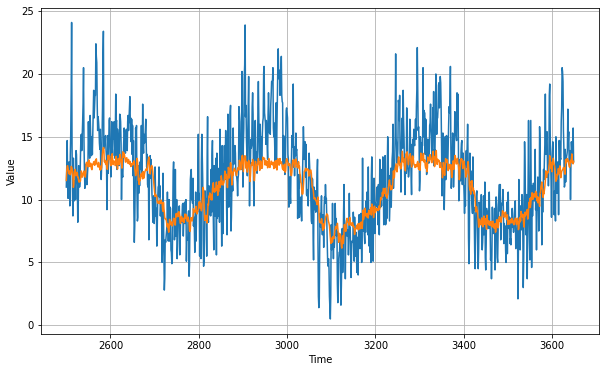

In [28]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [29]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

2.2201195

In [30]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.5274515 12.280069  12.682038  ... 12.873617  12.850216  13.04684  ]
